In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import choice
import warnings
from tictactoe import *
from tictactoe_helper import *
import imp

%matplotlib inline

https://www.neverstopbuilding.com/blog/2013/12/13/tic-tac-toe-understanding-the-minimax-algorithm13  
https://github.com/khpeek/Q-learning-Tic-Tac-Toe

### Outline:
- Game  
-- instantiates new Players, or accesses provided Players    
-- instantiates the Board  
-- keeps track of whose turn it is  
-- passes Board to Players when asking for a move, then updates Board with move  
-- keeps track of game outcome
- Board  
-- the board that is updated over the course of the game
- Player  
-- can exist on its own outside of Game  
-- has a policy  
-- selects a move  
-- can calculate if a board state is a win/loss/tie
-- remembers Board state from Player's previous move, and updates policy if needed  
-- if set to 'human', the Player just asks the human for input for each move

In [10]:
player1 = ttt_player('computer', 'X', epsilon=.9)
player2 = ttt_player('computer', 'O', epsilon=1)
#player2.alpha = 0

In [3]:
from decimal import Decimal
a = round(.234234, 3)
b = round(.234123, 3)
b

0.234

In [11]:
%%time
p1_2_training_game = train_computer_players(player1, player2, n_games=800000)
# 6 min with np.allclose
# 1 min 26s with round 3
# 1 min 25s with round 5

CPU times: user 3min 34s, sys: 1.89 s, total: 3min 36s
Wall time: 3min 42s


In [14]:
#p1_2_real_game = train_computer_players(player1, player2, n_games=100000, adj_pO_epsilon=False, adj_pX_epsilon=False)

In [5]:
# round 5, less exploration in training
state = ['_', '_', '_', '_', '_', '_', '_', '_', '_']
explore_policy(state, player1)

_ _ _
_ _ _
_ _ _
Initial board state

X _ _
_ _ _
_ _ _
Win probability = 0.50017000000000000

_ X _
_ _ _
_ _ _
Win probability = 0.50017000000000000

_ _ X
_ _ _
_ _ _
Win probability = 0.50017000000000000

_ _ _
X _ _
_ _ _
Win probability = 0.50017000000000000

_ _ _
_ X _
_ _ _
Win probability = 0.50017000000000000

_ _ _
_ _ X
_ _ _
Win probability = 0.50017000000000000

_ _ _
_ _ _
X _ _
Win probability = 0.50017000000000000

_ _ _
_ _ _
_ X _
Win probability = 0.50017000000000000

_ _ _
_ _ _
_ _ X
Win probability = 0.50017000000000000



In [6]:
# round 5
state = ['_', '_', '_', '_', '_', '_', '_', '_', '_']
explore_policy(state, player1)

_ _ _
_ _ _
_ _ _
Initial board state

X _ _
_ _ _
_ _ _
Win probability = 0.50017000000000000

_ X _
_ _ _
_ _ _
Win probability = 0.50017000000000000

_ _ X
_ _ _
_ _ _
Win probability = 0.50017000000000000

_ _ _
X _ _
_ _ _
Win probability = 0.50017000000000000

_ _ _
_ X _
_ _ _
Win probability = 0.50017000000000000

_ _ _
_ _ X
_ _ _
Win probability = 0.50017000000000000

_ _ _
_ _ _
X _ _
Win probability = 0.50017000000000000

_ _ _
_ _ _
_ X _
Win probability = 0.50017000000000000

_ _ _
_ _ _
_ _ X
Win probability = 0.50017000000000000



In [4]:
# round 3
state = ['_', '_', '_', '_', '_', '_', '_', '_', '_']
explore_policy(state, player1)

_ _ _
_ _ _
_ _ _
Initial board state

X _ _
_ _ _
_ _ _
Win probability = 0.51600000000000001

_ X _
_ _ _
_ _ _
Win probability = 0.51600000000000001

_ _ X
_ _ _
_ _ _
Win probability = 0.51600000000000001

_ _ _
X _ _
_ _ _
Win probability = 0.51600000000000001

_ _ _
_ X _
_ _ _
Win probability = 0.51600000000000001

_ _ _
_ _ X
_ _ _
Win probability = 0.51600000000000001

_ _ _
_ _ _
X _ _
Win probability = 0.51600000000000001

_ _ _
_ _ _
_ X _
Win probability = 0.51600000000000001

_ _ _
_ _ _
_ _ X
Win probability = 0.51600000000000001



In [12]:
# round 5, less exploration in training
state = ['X', '_', '_', '_', '_', '_', '_', '_', '_']
explore_policy(state, player2)

X _ _
_ _ _
_ _ _
Initial board state

X O _
_ _ _
_ _ _
Win probability = 0.13139000000000001

X _ O
_ _ _
_ _ _
Win probability = 0.29890000000000000

X _ _
O _ _
_ _ _
Win probability = 0.22916000000000000

X _ _
_ O _
_ _ _
Win probability = 0.50012999999999996

X _ _
_ _ O
_ _ _
Win probability = 0.30012000000000000

X _ _
_ _ _
O _ _
Win probability = 0.22486999999999999

X _ _
_ _ _
_ O _
Win probability = 0.26444000000000001

X _ _
_ _ _
_ _ O
Win probability = 0.33723999999999998



In [7]:
# round 5
state = ['X', '_', '_', '_', '_', '_', '_', '_', '_']
explore_policy(state, player2)

X _ _
_ _ _
_ _ _
Initial board state

X O _
_ _ _
_ _ _
Win probability = 0.26768999999999998

X _ O
_ _ _
_ _ _
Win probability = 0.30551000000000000

X _ _
O _ _
_ _ _
Win probability = 0.20562000000000000

X _ _
_ O _
_ _ _
Win probability = 0.50012999999999996

X _ _
_ _ O
_ _ _
Win probability = 0.39195999999999998

X _ _
_ _ _
O _ _
Win probability = 0.31724000000000002

X _ _
_ _ _
_ O _
Win probability = 0.26093000000000000

X _ _
_ _ _
_ _ O
Win probability = 0.29464000000000001



In [5]:
# round 3
state = ['X', '_', '_', '_', '_', '_', '_', '_', '_']
explore_policy(state, player2)

X _ _
_ _ _
_ _ _
Initial board state

X O _
_ _ _
_ _ _
Win probability = 0.22800000000000001

X _ O
_ _ _
_ _ _
Win probability = 0.22100000000000000

X _ _
O _ _
_ _ _
Win probability = 0.19000000000000000

X _ _
_ O _
_ _ _
Win probability = 0.51200000000000001

X _ _
_ _ O
_ _ _
Win probability = 0.23200000000000001

X _ _
_ _ _
O _ _
Win probability = 0.23300000000000001

X _ _
_ _ _
_ O _
Win probability = 0.26200000000000001

X _ _
_ _ _
_ _ O
Win probability = 0.23400000000000001



In [6]:
state = ['X', '_', '_', '_', '_', '_', '_', '_', '_']
explore_policy(state, player2)

X _ _
_ _ _
_ _ _
Initial board state

X O _
_ _ _
_ _ _
Win probability = 0.19400000000000001

X _ O
_ _ _
_ _ _
Win probability = 0.31800000000000000

X _ _
O _ _
_ _ _
Win probability = 0.23400000000000001

X _ _
_ O _
_ _ _
Win probability = 0.51200000000000001

X _ _
_ _ O
_ _ _
Win probability = 0.22800000000000001

X _ _
_ _ _
O _ _
Win probability = 0.28799999999999998

X _ _
_ _ _
_ O _
Win probability = 0.34200000000000003

X _ _
_ _ _
_ _ O
Win probability = 0.18700000000000000



In [15]:
# round 5, less exploration in training
state = ['X', 'O', '_', '_', '_', '_', '_', '_', '_']
explore_policy(state, player1)

X O _
_ _ _
_ _ _
Initial board state

X O X
_ _ _
_ _ _
Win probability = 0.58716000000000002

X O _
X _ _
_ _ _
Win probability = 0.99995999999999996

X O _
_ X _
_ _ _
Win probability = 0.99992999999999999

X O _
_ _ X
_ _ _
Win probability = 0.79479999999999995

X O _
_ _ _
X _ _
Win probability = 0.99995999999999996

X O _
_ _ _
_ X _
Win probability = 0.50246999999999997

X O _
_ _ _
_ _ X
Win probability = 0.71940000000000004



In [8]:
# round 5
state = ['X', 'O', '_', '_', '_', '_', '_', '_', '_']
explore_policy(state, player1)

X O _
_ _ _
_ _ _
Initial board state

X O X
_ _ _
_ _ _
Win probability = 0.63527000000000000

X O _
X _ _
_ _ _
Win probability = 0.97238999999999998

X O _
_ X _
_ _ _
Win probability = 0.99873000000000001

X O _
_ _ X
_ _ _
Win probability = 0.74077999999999999

X O _
_ _ _
X _ _
Win probability = 0.99995999999999996

X O _
_ _ _
_ X _
Win probability = 0.50048000000000004

X O _
_ _ _
_ _ X
Win probability = 0.73607000000000000



In [6]:
# round 3
state = ['X', 'O', '_', '_', '_', '_', '_', '_', '_']
explore_policy(state, player1)

X O _
_ _ _
_ _ _
Initial board state

X O X
_ _ _
_ _ _
Win probability = 0.66100000000000003

X O _
X _ _
_ _ _
Win probability = 0.99600000000000000

X O _
_ X _
_ _ _
Win probability = 0.99600000000000000

X O _
_ _ X
_ _ _
Win probability = 0.76500000000000001

X O _
_ _ _
X _ _
Win probability = 0.94699999999999995

X O _
_ _ _
_ X _
Win probability = 0.59599999999999997

X O _
_ _ _
_ _ X
Win probability = 0.70799999999999996



In [8]:
state = ['_', '_', '_', 'X', '_', '_', '_', '_', '_']
explore_policy(state, player2)

_ _ _
X _ _
_ _ _
Initial board state

O _ _
X _ _
_ _ _
Win probability = 0.50001414832167068

_ O _
X _ _
_ _ _
Win probability = 0.28616200204709702

_ _ O
X _ _
_ _ _
Win probability = 0.38382233248558001

_ _ _
X O _
_ _ _
Win probability = 0.50000891392253322

_ _ _
X _ O
_ _ _
Win probability = 0.50001442069110003

_ _ _
X _ _
O _ _
Win probability = 0.50068053430214110

_ _ _
X _ _
_ O _
Win probability = 0.22228104457487960

_ _ _
X _ _
_ _ O
Win probability = 0.31550165713188472



In [8]:
# After real games
state = ['_', '_', '_', 'X', '_', '_', '_', '_', '_']
explore_policy(state, player2)

_ _ _
X _ _
_ _ _
Initial board state

O _ _
X _ _
_ _ _
Win probability = 0.51100000000000001

_ O _
X _ _
_ _ _
Win probability = 0.22600000000000001

_ _ O
X _ _
_ _ _
Win probability = 0.42399999999999999

_ _ _
X O _
_ _ _
Win probability = 0.51200000000000001

_ _ _
X _ O
_ _ _
Win probability = 0.51100000000000001

_ _ _
X _ _
O _ _
Win probability = 0.51100000000000001

_ _ _
X _ _
_ O _
Win probability = 0.37200000000000000

_ _ _
X _ _
_ _ O
Win probability = 0.24199999999999999



In [16]:
# round 5, less exploration in training
state = ['_','X','O','_','X','_','O','_','_']
explore_policy(state, player1)

_ X O
_ X _
O _ _
Initial board state

X X O
_ X _
O _ _
Win probability = 0.99995999999999996

_ X O
X X _
O _ _
Win probability = 0.97382999999999997

_ X O
_ X X
O _ _
Win probability = 0.99768000000000001

_ X O
_ X _
O X _
Win probability = 1.00000000000000000

_ X O
_ X _
O _ X
Win probability = 0.99712999999999996



In [39]:
test_computer(player1, n_games=1)

_ _ _
_ _ _
_ _ _

Player X's turn:
best move ixs:  [0, 1, 2, 3, 4, 5, 6, 7, 8]
max_prob:  0.5
X _ _
_ _ _
_ _ _

Player O's turn:
Enter the row and column you want to make a mark in, using the format x,y 2,2
X _ _
_ O _
_ _ _

Player X's turn:
best move ixs:  [1, 2, 3, 5, 6, 7, 8]
max_prob:  0.5
X _ _
_ O _
_ X _

Player O's turn:
Enter the row and column you want to make a mark in, using the format x,y 3,1
X _ _
_ O _
O X _

Player X's turn:
best move ixs:  [2]
max_prob:  0.5
X _ X
_ O _
O X _

Player O's turn:
Enter the row and column you want to make a mark in, using the format x,y 1,2
X O X
_ O _
O X _

Player X's turn:
best move ixs:  [3, 5, 8]
max_prob:  0.5
X O X
_ O _
O X X

Player O's turn:
Enter the row and column you want to make a mark in, using the format x,y 2,3
X O X
_ O O
O X X

Player X's turn:
best move ixs:  [3]
max_prob:  0.5
X O X
X O O
O X X

The game is a tie!


### Player 1 and Player 2 win stats

In [9]:
p1_2_train_scores, p1_2_train_scores_agg = compute_player_stats(p1_2_training_game, 'playerO')

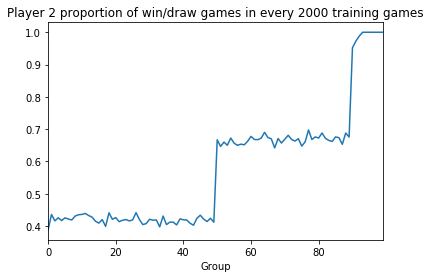

In [10]:
p1_2_train_scores_agg.plot()
plt.title('Player 2 proportion of win/draw games in every 2000 training games')
plt.xlabel('Group');

In [11]:
player1.set_epsilon(0)
player2.set_epsilon(0)
p1_2_real_game = train_computer_players(player1, player2, n_games=20000, adj_pX_epsilon=False, adj_pO_epsilon=False)

In [12]:
p1_2_real_scores, p1_2_real_scores_agg = compute_player_stats(p1_2_real_game, 'playerX')

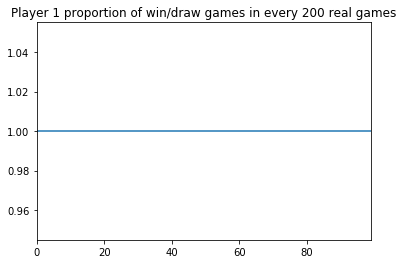

In [13]:
p1_2_real_scores_agg.plot()
plt.title('Player 1 proportion of win/draw games in every 200 real games');

In [14]:
p1_2_real_scores.score.mean()

0.5

### Player 3 win stats

In [15]:
player3 = ttt_player('computer', 'O', epsilon=.9)

In [16]:
player1.set_epsilon(0)
player1.alpha = 0
p1_3_training_game = train_computer_players(player1, player3, adj_pX_epsilon=False)

In [17]:
len(player3.policy)


1496

In [55]:
state = ['X', '_', '_', '_', '_', '_', '_', '_', '_']
explore_policy(state, player3)

X _ _
_ _ _
_ _ _
Initial board state

X O _
_ _ _
_ _ _
Win probability = 0.00000000011908208

X _ O
_ _ _
_ _ _
Win probability = 0.00000000001614477

X _ _
O _ _
_ _ _
Win probability = 0.00000000039924351

X _ _
_ O _
_ _ _
Win probability = 0.50000000000000000

X _ _
_ _ O
_ _ _
Win probability = 0.00000000000690413

X _ _
_ _ _
O _ _
Win probability = 0.00000000101490790

X _ _
_ _ _
_ O _
Win probability = 0.00000000420971647

X _ _
_ _ _
_ _ O
Win probability = 0.00000000627944241



In [19]:
p1_3_train_scores, p1_3_train_scores_agg = compute_player_stats(p1_3_training_game, 'playerO')

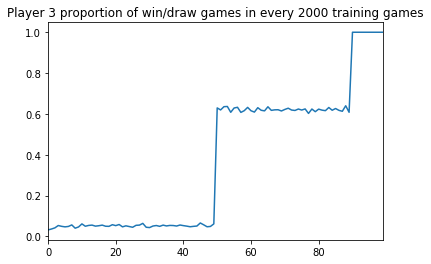

In [20]:
p1_3_train_scores_agg.plot()
plt.title('Player 3 proportion of win/draw games in every 2000 training games');

In [21]:
player3.set_epsilon(0)
p1_3_real_game = train_computer_players(player1, player3, n_games=20000, adj_pX_epsilon=False, adj_pO_epsilon=False)

In [22]:
p1_3_real_scores, p1_3_real_scores_agg = compute_player_stats(p1_3_real_game, 'playerO')

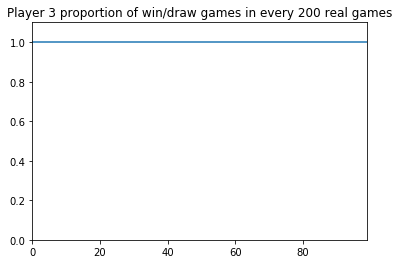

In [23]:
p1_3_real_scores_agg.plot()
plt.title('Player 3 proportion of win/draw games in every 200 real games')
plt.ylim(0,1.1);

In [24]:
p1_3_more_training = train_computer_players(player1, player3, n_games=50000,
                                            adj_pX_epsilon=False, adj_pO_epsilon=False)

In [25]:
p1_3_real_scores2, p1_3_real_scores_agg2 = compute_player_stats(p1_3_more_training, 'playerO')

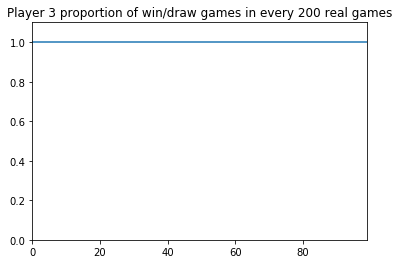

In [26]:
p1_3_real_scores_agg2.plot()
plt.title('Player 3 proportion of win/draw games in every 200 real games')
plt.ylim(0,1.1);

In [35]:
player3.epsilon

0

### Figure out if Player 3 is buggy

In [61]:
explore_policy(['X','X','_','O','O','_','_','_','_'], player1)

X X _
O O _
_ _ _
Initial board state

X X X
O O _
_ _ _
Win probability = 1.00000000000000000

X X _
O O X
_ _ _
Win probability = 0.60141331827904998

X X _
O O _
X _ _
Win probability = 0.07396816663904195

X X _
O O _
_ X _
Win probability = 0.13516021384178606

X X _
O O _
_ _ X
Win probability = 0.04719398929906676



In [62]:
explore_policy(['X','X','_','_','O','_','_','_','_'], player3)

X X _
_ O _
_ _ _
Initial board state

X X O
_ O _
_ _ _
Win probability = 0.50000000000000000

X X _
O O _
_ _ _
Win probability = 0.00000041041550522

X X _
_ O O
_ _ _
Win probability = 0.00000045601722802

X X _
_ O _
O _ _
Win probability = 0.00000000000000000

X X _
_ O _
_ O _
Win probability = 0.00000000073752089

X X _
_ O _
_ _ O
Win probability = 0.00000002651728188



In [63]:
explore_policy(['X','X','_','_','O','_','_','_','_'], player2)

X X _
_ O _
_ _ _
Initial board state

X X O
_ O _
_ _ _
Win probability = 0.50000000000000089

X X _
O O _
_ _ _
Win probability = 0.20712923576225445

X X _
_ O O
_ _ _
Win probability = 0.04768837211788724

X X _
_ O _
O _ _
Win probability = 0.14612109711042437

X X _
_ O _
_ O _
Win probability = 0.11772295798026493

X X _
_ O _
_ _ O
Win probability = 0.10103516433642107



In [64]:
explore_policy(['X','X','O','_','O','_','X','_','_'], player3)

X X O
_ O _
X _ _
Initial board state

X X O
O O _
X _ _
Win probability = 0.50000000000000000

X X O
_ O O
X _ _
Win probability = 0.00001075736654947

X X O
_ O _
X O _
Win probability = 0.00000004041652473

X X O
_ O _
X _ O
Win probability = 0.00000024234625168



In [159]:
a = a+.1*-a
print a

0.00257688760366


In [65]:
explore_policy(['X','X','O','_','O','_','X','_','_'], player2)

X X O
_ O _
X _ _
Initial board state

X X O
O O _
X _ _
Win probability = 0.50000000000000044

X X O
_ O O
X _ _
Win probability = 0.14089767531755445

X X O
_ O _
X O _
Win probability = 0.00079063669212751

X X O
_ O _
X _ O
Win probability = 0.13628249080899935



In [66]:
explore_policy(['X','X','O','_','O','_','X','_','O'], player1)

X X O
_ O _
X _ O
Initial board state

X X O
X O _
X _ O
Win probability = 1.00000000000000000

X X O
_ O X
X _ O
Win probability = 0.50000000000000044

X X O
_ O _
X X O
Win probability = 0.00292556693979397



In [67]:
explore_policy(['X','X','O','_','O','X','X','_','O'], player3)

X X O
_ O X
X _ O
Initial board state

X X O
O O X
X _ O
Win probability = 0.50000000000000000

X X O
_ O X
X O O
Win probability = 0.00000000059739192



In [96]:
test_computer(player1, n_games=1)

_ _ _
_ _ _
_ _ _

Player X's turn:
best move ixs:  [0, 1, 2, 3, 4, 5, 6, 7, 8]
max_prob:  0.5
X _ _
_ _ _
_ _ _

Player O's turn:
Enter the row and column you want to make a mark in, using the format x,y 2,2
X _ _
_ O _
_ _ _

Player X's turn:
best move ixs:  [1, 2, 3, 5, 6, 7, 8]
max_prob:  0.5
X _ _
_ O _
_ _ X

Player O's turn:
Enter the row and column you want to make a mark in, using the format x,y 3,2
X _ _
_ O _
_ O X

Player X's turn:
best move ixs:  [1]
max_prob:  0.5
X X _
_ O _
_ O X

Player O's turn:
Enter the row and column you want to make a mark in, using the format x,y 1,3
X X O
_ O _
_ O X

Player X's turn:
best move ixs:  [6]
max_prob:  0.5
X X O
_ O _
X O X

Player O's turn:
Enter the row and column you want to make a mark in, using the format x,y 2,1
X X O
O O _
X O X

Player X's turn:
best move ixs:  [5]
max_prob:  0.5
X X O
O O X
X O X

The game is a tie!


In [70]:
len(player3.policy)

1751

In [71]:
explore_policy(['_','_','_','_','_','_','_','_','_'], player1)

_ _ _
_ _ _
_ _ _
Initial board state

X _ _
_ _ _
_ _ _
Win probability = 0.50000000000000133

_ X _
_ _ _
_ _ _
Win probability = 0.50000234415819367

_ _ X
_ _ _
_ _ _
Win probability = 0.50000000286905710

_ _ _
X _ _
_ _ _
Win probability = 0.50000169618567569

_ _ _
_ X _
_ _ _
Win probability = 0.50000038831593496

_ _ _
_ _ X
_ _ _
Win probability = 0.50000317155810037

_ _ _
_ _ _
X _ _
Win probability = 0.50000000073787887

_ _ _
_ _ _
_ X _
Win probability = 0.50000222094548930

_ _ _
_ _ _
_ _ X
Win probability = 0.50000000860830762



In [8]:
# round 5, less exploration in training
explore_policy(['_','X','O','O','X','X','O','_','_'], player1)

_ X O
O X X
O _ _
Initial board state

X X O
O X X
O _ _
Win probability = 0.96011000000000002

_ X O
O X X
O X _
Win probability = 1.00000000000000000

_ X O
O X X
O _ X
Win probability = 0.00951000000000000



In [72]:
explore_policy(['_','X','O','O','X','X','O','_','_'], player1)

_ X O
O X X
O _ _
Initial board state

X X O
O X X
O _ _
Win probability = 0.98986222020477732

_ X O
O X X
O X _
Win probability = 1.00000000000000000

_ X O
O X X
O _ X
Win probability = 0.05757427739361200



### What is Player 1's deal?

In [73]:
explore_policy(['X','X','_','_','O','_','_','_','_'], player3)

X X _
_ O _
_ _ _
Initial board state

X X O
_ O _
_ _ _
Win probability = 0.50000000000000000

X X _
O O _
_ _ _
Win probability = 0.00000041041550522

X X _
_ O O
_ _ _
Win probability = 0.00000045601722802

X X _
_ O _
O _ _
Win probability = 0.00000000000000000

X X _
_ O _
_ O _
Win probability = 0.00000000073752089

X X _
_ O _
_ _ O
Win probability = 0.00000002651728188



In [46]:
player3.set_epsilon(.5)
test_computer(player3, n_games=1)

_ _ _
_ _ _
_ _ _

Player X's turn:
Enter the row and column you want to make a mark in, using the format x,y 1,1
X _ _
_ _ _
_ _ _

Player O's turn:
X _ _
O _ _
_ _ _

Player X's turn:
Enter the row and column you want to make a mark in, using the format x,y 1,3
X _ X
O _ _
_ _ _

Player O's turn:
best move ixs:  [1, 5, 7, 8]
max_prob:  0.5
X _ X
O _ O
_ _ _

Player X's turn:
Enter the row and column you want to make a mark in, using the format x,y 1,2
X X X
O _ O
_ _ _

Player X wins!


In [74]:
explore_policy(['X','_','X','O','_','_','_','_','_'], player3)

X _ X
O _ _
_ _ _
Initial board state

X O X
O _ _
_ _ _


KeyError: ('X', 'O', 'X', 'O', '_', '_', '_', '_', '_')

In [78]:
explore_policy(['X','_','_','O','_','_','_','_','_'], player1)

X _ _
O _ _
_ _ _
Initial board state

X X _
O _ _
_ _ _
Win probability = 0.88209304572364799

X _ X
O _ _
_ _ _
Win probability = 0.87876867161072036

X _ _
O X _
_ _ _
Win probability = 0.99999997770097437

X _ _
O _ X
_ _ _
Win probability = 0.50000764972816292

X _ _
O _ _
X _ _
Win probability = 0.63998814404340776

X _ _
O _ _
_ X _
Win probability = 0.69013965920311970

X _ _
O _ _
_ _ X
Win probability = 0.77824843059546378



In [75]:
explore_policy(['X','X','O','_','O','_','X','_','_'], player3)

X X O
_ O _
X _ _
Initial board state

X X O
O O _
X _ _
Win probability = 0.50000000000000000

X X O
_ O O
X _ _
Win probability = 0.00001075736654947

X X O
_ O _
X O _
Win probability = 0.00000004041652473

X X O
_ O _
X _ O
Win probability = 0.00000024234625168



# Mental Bookmark
- Rounding the probabilities doesn't seem to affect the results too much (so rounding to 4 or 5 decimals is fine). When probabilities are wrong, it seems to be because the players haven't trained long enough to adjust them.
- Changing P1's alpha to 0 eliminated the issue where P3 didn't explore the possibility space (I think P1 was always playing the same move because it learned that that move was "better," but that was just because P3 played that position poorly and lost.)
- P1 doesn't prefer corners. What if I train it against a P2 with a constant epsilon = .9? Then it should learn that corners are better because corners lead to more game paths where O loses.  
-- Nope, X prefers the center if O is moving randomly (or close to randomly). But why? I worked out the numbers and corners should be slightly better.
- consider "shaping." Player 3 learns faster against expert Player 1 than if Player 1 is set to explore? Create these players:  
-- Expert Player X, explores all moves and is an expert player  
-- Apprentice Player O, trains against Expert X and therefore only explores the best moves for X (should train faster than New Expert O)  
-- Random Player, compare win rate when an Expert plays Random vs. when Apprentice plays Random (Apprentice should perform poorly when Random makes non-Expert moves)
-- New Expert O, trains against Expert X while X epsilon > .5. Should perform better against Random than Apprentice.  
- create readme
- create a module that I can import?
- give computer players one policy dictionary to share?  
-- they'll train twice as fast, and have all entries
- Try training ExpertX (alpha = .1) vs. RandomO. Expert X should learn to prefer corners as a first move, because they lead to games where a greater proportion of the moves are dangerous for O.

## Stuff to write about
- Implementation  
--  training player3 with player1's learning rate != 0 somehow resulted in p3 not exploring a lot of paths. I think it's because p1's policy changed a bunch in response to p3's erratic behavior as a learner, and thus p1 learned some new "best" moves and stuck with those for a while.  
-- have to continue training after stopping exploration, to let policies settle


- Interesting stuff  
-- this algo will win either quickly or slowly if it has equal probability of winning with either. As will minimax if you don't do alpha-beta pruning.  
-- if board is [\_,X,O,\_,X,\_,O,\_,\_], any move by X has 100% chance of winning!  
-- "shaping behavior": train against expert opponent to explore the best moves faster